In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', None )
pd.set_option('display.max_columns', None )
#pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
data_Final = pd.read_csv('data_Final.csv', index_col='OSEBuildingID')
data_Final.head()

,ENERGYSTARScore_mean,SiteEnergyUseWN(kBtu)_mean,GHGEmissions(MetricTonsCO2e)_mean,Neighborhood_2015,age,NumberofFloors_mean,PrimaryPropertyType_2015,LargestPropertyUseTypeGFA_mean,PropertyGFAParking_mean,util_steam,util_elec,util_gaz
OSEBuildingID,,,,,,,,,,,,
1,62.5,7277224.50,249.705,DOWNTOWN,88,12.0,Hotel,88434.0,0.0,0.153106,0.326086,0.520808
2,56.0,8715133.50,279.685,DOWNTOWN,19,11.0,Hotel,83880.0,15064.0,0.153106,0.326086,0.520808
3,30.5,74721692.00,2075.380,DOWNTOWN,46,41.0,Hotel,756868.0,98359.0,0.153106,0.326086,0.520808
5,28.5,17655122.25,1111.385,DOWNTOWN,89,10.0,Hotel,61320.0,0.0,0.153106,0.326086,0.520808
8,71.0,14867373.00,506.355,DOWNTOWN,35,18.0,Hotel,123445.0,37230.0,0.153106,0.326086,0.520808


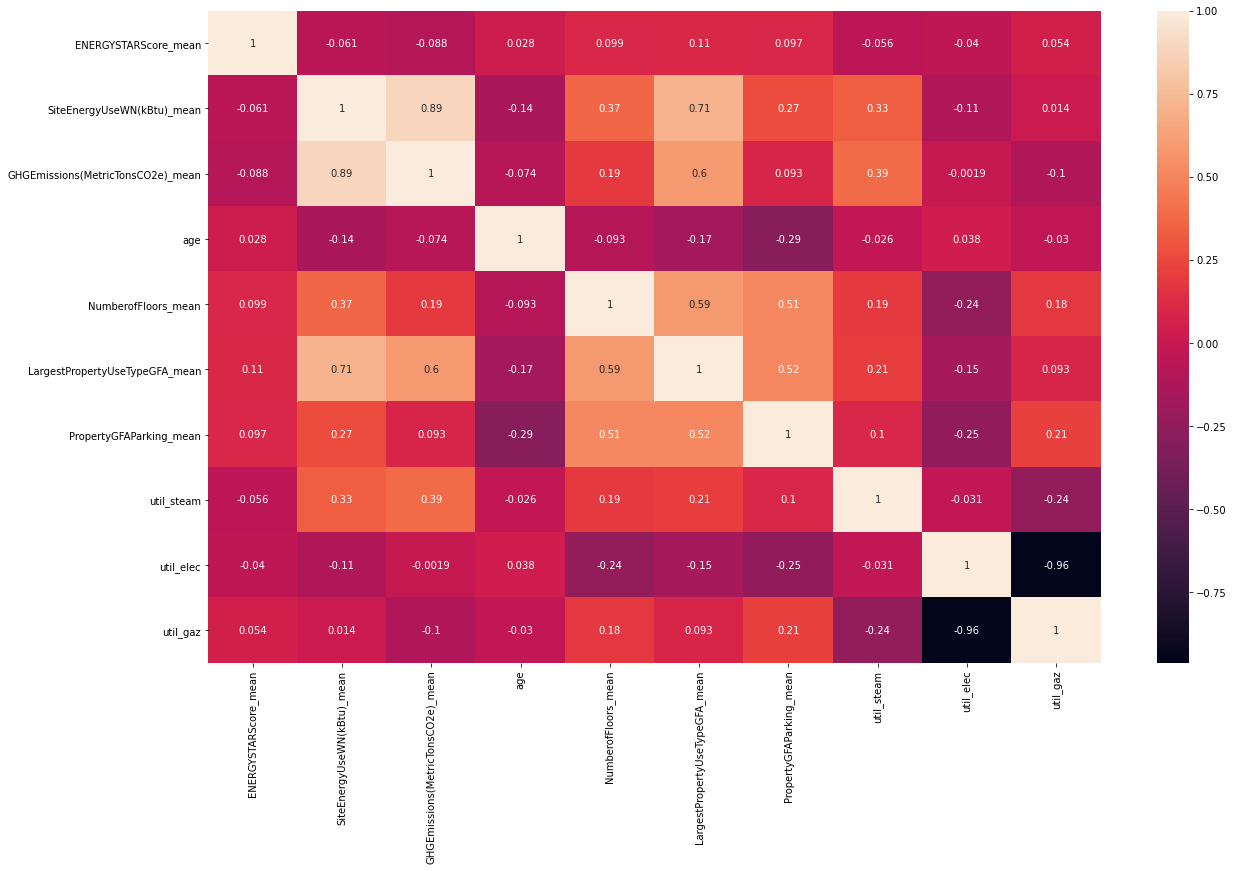

In [3]:
plt.figure(figsize=(20,12))
sns.heatmap(data_Final.corr(), annot=True)
plt.show()

In [4]:
data_Final.isna().sum()

ENERGYSTARScore_mean                 514
SiteEnergyUseWN(kBtu)_mean             0
GHGEmissions(MetricTonsCO2e)_mean      0
Neighborhood_2015                      0
age                                    0
NumberofFloors_mean                    0
PrimaryPropertyType_2015               0
LargestPropertyUseTypeGFA_mean         0
PropertyGFAParking_mean                0
util_steam                             0
util_elec                              0
util_gaz                               0
dtype: int64

## preprocessing avec normalisation

In [5]:
colonne_X = [ 'Neighborhood_2015', 'age', 'LargestPropertyUseTypeGFA_mean',\
             'PropertyGFAParking_mean', 'NumberofFloors_mean','PrimaryPropertyType_2015',\
            'util_elec','util_gaz','util_steam']
data_X = data_Final[colonne_X]


In [6]:
data_X.head()

,Neighborhood_2015,age,LargestPropertyUseTypeGFA_mean,PropertyGFAParking_mean,NumberofFloors_mean,PrimaryPropertyType_2015,util_elec,util_gaz,util_steam
OSEBuildingID,,,,,,,,,
1,DOWNTOWN,88,88434.0,0.0,12.0,Hotel,0.326086,0.520808,0.153106
2,DOWNTOWN,19,83880.0,15064.0,11.0,Hotel,0.326086,0.520808,0.153106
3,DOWNTOWN,46,756868.0,98359.0,41.0,Hotel,0.326086,0.520808,0.153106
5,DOWNTOWN,89,61320.0,0.0,10.0,Hotel,0.326086,0.520808,0.153106
8,DOWNTOWN,35,123445.0,37230.0,18.0,Hotel,0.326086,0.520808,0.153106


In [7]:
def encodage(df):
    df = pd.get_dummies(df,columns=['Neighborhood_2015','PrimaryPropertyType_2015'])
    return df


In [8]:
def imputation(df):
    return df.dropna(axis=0)

In [9]:
def preprocessing(df):

    df['Log_NumberofFloors_mean']= np.log1p(df['NumberofFloors_mean'])
    df.drop(columns='NumberofFloors_mean', inplace=True)

    df['Log_LargestPropertyUseTypeGFA']= np.log1p(df['LargestPropertyUseTypeGFA_mean'])
    df.drop(columns='LargestPropertyUseTypeGFA_mean', inplace=True)

    df['Log_PropertyGFAParking_mean']= np.log1p(df['PropertyGFAParking_mean'])
    df.drop(columns='PropertyGFAParking_mean', inplace=True)

    return df

In [10]:
print(data_X.shape)
data_X = encodage(data_X)
data_X = imputation(data_X)
data_X = preprocessing(data_X)
print(data_X.shape)
    

(1630, 9)
(1630, 42)


In [11]:
data_y = pd.DataFrame(np.log(data_Final['SiteEnergyUseWN(kBtu)_mean']))

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.15)

print('X_train',X_train.shape)
print('y_train',y_train.shape)
print('X_test',X_test.shape)
print('y_test',y_test.shape)


X_train (1385, 42)
y_train (1385, 1)
X_test (245, 42)
y_test (245, 1)


## premiere regression

In [13]:
from sklearn import metrics

def evaluation( model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    
    rsq_test = model.score(X_test, y_test)

    #prédire sur le jeu de test
    y_test_pred = model.predict(X_test)

    # calculer la RMSLE sur le jeu de test
    #RMSLE (Root Mean Squared Log Error)
    rmsle = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
        
    return [rsq_test,rmsle]

# LinearRegression

In [20]:
from sklearn.linear_model import LinearRegression

print("Consommation Energie R² RMSLE", evaluation(LinearRegression(), X_train, X_test, y_train, y_test))
        
    

Consommation Energie R² RMSLE [0.7100665455826873, 0.7039358155352189]


# dummy Regression

In [21]:
from sklearn.dummy import DummyRegressor

print("Consommation Energie R² RMSLE", evaluation(DummyRegressor(), X_train, X_test, y_train, y_test))
        

Consommation Energie R² RMSLE [-0.0029036215066404747, 1.3092226104195286]


# Ridge Regression

In [22]:
from sklearn.linear_model import Ridge

print("Consommation Energie R² RMSLE", evaluation(Ridge(alpha=0.5), X_train, X_test, y_train, y_test))

Consommation Energie R² RMSLE [0.709608326312066, 0.7044918562525887]


### consommation energie

In [18]:
from sklearn.model_selection import GridSearchCV

params_grid = { 'alpha':np.logspace(-2,4,30)}
print( params_grid)
grid = GridSearchCV(Ridge(),params_grid, cv=5)
grid.fit(X_train, y_train)
#print(grid.cv_results_)
print(grid.best_score_,grid.best_params_)
print("Consommation Energie R² RMSLE", evaluation(grid.best_estimator_, X_train, X_test, y_train, y_test))


{'alpha': array([1.00000000e-02, 1.61026203e-02, 2.59294380e-02, 4.17531894e-02,
       6.72335754e-02, 1.08263673e-01, 1.74332882e-01, 2.80721620e-01,
       4.52035366e-01, 7.27895384e-01, 1.17210230e+00, 1.88739182e+00,
       3.03919538e+00, 4.89390092e+00, 7.88046282e+00, 1.26896100e+01,
       2.04335972e+01, 3.29034456e+01, 5.29831691e+01, 8.53167852e+01,
       1.37382380e+02, 2.21221629e+02, 3.56224789e+02, 5.73615251e+02,
       9.23670857e+02, 1.48735211e+03, 2.39502662e+03, 3.85662042e+03,
       6.21016942e+03, 1.00000000e+04])}
0.6678717544076129 {'alpha': 1.1721022975334805}
Consommation Energie R² RMSLE [0.7206822536438195, 0.6942016749049258]


In [19]:
params_grid = { 'alpha':np.linspace(0.1,2,20)}
print( params_grid)
grid = GridSearchCV(Ridge(),params_grid, cv=5)
grid.fit(X_train, y_train)
#print(grid.cv_results_)
print(grid.best_score_,grid.best_params_)
print("Consommation Energie R² RMSLE", evaluation(grid.best_estimator_, X_train, X_test, y_train, y_test))


{'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ])}
0.6678756668621436 {'alpha': 1.3}
Consommation Energie R² RMSLE [0.720663409169125, 0.694225092044417]


# LASSO

In [23]:
from sklearn.linear_model import Lasso

print("Consommation Energie R² RMSLE", evaluation(Lasso(alpha=0.1), X_train, X_test, y_train, y_test))
     

Consommation Energie R² RMSLE [0.5406611310095061, 0.8860342205403077]


### consommation energie

In [21]:
params_grid = { 'alpha':np.logspace(-4,2,30)}
print( params_grid)
grid = GridSearchCV(Lasso(),params_grid, cv=5)
grid.fit(X_train, y_train)
#print(grid.cv_results_)
print(grid.best_score_,grid.best_params_)
print("Consommation Energie R² RMSLE", evaluation(grid.best_estimator_, X_train, X_test, y_train, y_test))


{'alpha': array([1.00000000e-04, 1.61026203e-04, 2.59294380e-04, 4.17531894e-04,
       6.72335754e-04, 1.08263673e-03, 1.74332882e-03, 2.80721620e-03,
       4.52035366e-03, 7.27895384e-03, 1.17210230e-02, 1.88739182e-02,
       3.03919538e-02, 4.89390092e-02, 7.88046282e-02, 1.26896100e-01,
       2.04335972e-01, 3.29034456e-01, 5.29831691e-01, 8.53167852e-01,
       1.37382380e+00, 2.21221629e+00, 3.56224789e+00, 5.73615251e+00,
       9.23670857e+00, 1.48735211e+01, 2.39502662e+01, 3.85662042e+01,
       6.21016942e+01, 1.00000000e+02])}


C:\Users\paps\anaconda3\envs\openclass\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24141214249345921, tolerance: 0.1757966824363181
  model = cd_fast.enet_coordinate_descent(


0.6676404722119794 {'alpha': 0.0006723357536499335}
Consommation Energie R² RMSLE [0.722709505789338, 0.6916778741400281]


In [22]:
params_grid = { 'alpha':np.linspace(0.0005,0.002,21)}
print( params_grid)
grid = GridSearchCV(Lasso(),params_grid, cv=5)
grid.fit(X_train, y_train)
#print(grid.cv_results_)
print(grid.best_score_,grid.best_params_)
print("Consommation Energie R² RMSLE", evaluation(grid.best_estimator_, X_train, X_test, y_train, y_test))


{'alpha': array([0.0005  , 0.000575, 0.00065 , 0.000725, 0.0008  , 0.000875,
       0.00095 , 0.001025, 0.0011  , 0.001175, 0.00125 , 0.001325,
       0.0014  , 0.001475, 0.00155 , 0.001625, 0.0017  , 0.001775,
       0.00185 , 0.001925, 0.002   ])}
0.6676421271429624 {'alpha': 0.00065}
Consommation Energie R² RMSLE [0.7226697206047621, 0.6917274927628384]


# DECISION TREE

In [24]:
from sklearn.tree import DecisionTreeRegressor

print("Consommation Energie R² RMSLE", evaluation(DecisionTreeRegressor(), X_train, X_test, y_train, y_test))
        

Consommation Energie R² RMSLE [0.3855765384594656, 1.0247496828851326]


In [24]:
params_grid = { 'criterion': ['mse', 'friedman_mse', 'mae'],
              'max_depth' : np.linspace(1,7,7)}
print( params_grid)
grid = GridSearchCV(DecisionTreeRegressor(),params_grid, cv=5)
grid.fit(X_train, y_train)
#print(grid.cv_results_)
print(grid.best_score_,grid.best_params_)
print("Consommation Energie R² RMSLE", evaluation(grid.best_estimator_, X_train, X_test, y_train, y_test))


{'criterion': ['mse', 'friedman_mse', 'mae'], 'max_depth': array([1., 2., 3., 4., 5., 6., 7.])}
0.5971102915503756 {'criterion': 'mae', 'max_depth': 5.0}
Consommation Energie R² RMSLE [0.7136509747397752, 0.70288495427251]


# kneighbors

In [25]:
from sklearn.neighbors import KNeighborsRegressor

print("Consommation Energie R² RMSLE", evaluation(KNeighborsRegressor(n_neighbors=5), X_train, X_test, y_train, y_test))         

Consommation Energie R² RMSLE [0.4523313398971648, 0.9674818847371056]


In [26]:
params_grid = { 'n_neighbors' : np.linspace(1,15,15,dtype=int)}
print( params_grid)
grid = GridSearchCV(KNeighborsRegressor(),params_grid, cv=5)
grid.fit(X_train, y_train)
#print(grid.cv_results_)
print(grid.best_score_,grid.best_params_)
print("Consommation Energie R² RMSLE", evaluation(grid.best_estimator_, X_train, X_test, y_train, y_test))


{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])}
0.4073161431533586 {'n_neighbors': 5}
Consommation Energie R² RMSLE [0.46919135716528115, 0.956985561241621]


# RandomForest

In [26]:
from sklearn.ensemble import RandomForestRegressor

print("Consommation Energie R² RMSLE", evaluation(RandomForestRegressor(), X_train, X_test, \
                                                  y_train.values.ravel(), y_test.values.ravel()))

Consommation Energie R² RMSLE [0.6842962201447413, 0.7345541015348087]


### consommation energie

In [28]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train.values.ravel())

print(rf_random.best_params_)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.2min finished


{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 110, 'bootstrap': True}


In [29]:
from sklearn.model_selection import GridSearchCV
import timeit

start_time = timeit.default_timer()

# Create the parameter grid based on the results of random search 
params_grid = {
    'bootstrap': [True],
    'max_depth': [100 , 110, None ],
    'max_features': ['auto'],
    'min_samples_leaf': [3,4,5],
    'min_samples_split': [2,3,4],
    'n_estimators': [150, 200, 250]
}             
print( params_grid)
grid = GridSearchCV(RandomForestRegressor(),params_grid, cv=5)
grid.fit(X_train, y_train.values.ravel())
#print(grid.cv_results_)

elapsed = timeit.default_timer() - start_time
time = elapsed
print(f'resultat en {time:.2f}s')
print(grid.best_score_,grid.best_params_)
print("Consommation Energie R² RMSLE", evaluation(grid.best_estimator_, X_train, X_test,\
                                                  y_train.values.ravel(), y_test.values.ravel()))


{'bootstrap': [True], 'max_depth': [100, 110, None], 'max_features': ['auto'], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [2, 3, 4], 'n_estimators': [150, 200, 250]}
resultat en 296.09s
0.6633416583262998 {'bootstrap': True, 'max_depth': 110, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 150}
Consommation Energie R² RMSLE [0.7231803067333147, 0.6910904379596058]


# AdaBoost

In [27]:
from sklearn.ensemble import AdaBoostRegressor

print("Consommation Energie R² RMSLE", evaluation(AdaBoostRegressor(), X_train, X_test,\
                                                  y_train.values.ravel(), y_test.values.ravel()))
        

Consommation Energie R² RMSLE [0.6005281615170681, 0.8262795063827908]


### consommation energie

In [31]:
from sklearn.model_selection import RandomizedSearchCV

# Create the random grid
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'learning_rate': [0.01,0.05,0.1,0.3,1],
               'loss': ['linear', 'square', 'exponential']}
print(random_grid)

rf = AdaBoostRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train.values.ravel())

print(rf_random.best_params_)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'learning_rate': [0.01, 0.05, 0.1, 0.3, 1], 'loss': ['linear', 'square', 'exponential']}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.1min finished


{'n_estimators': 2000, 'loss': 'exponential', 'learning_rate': 0.01}


In [32]:
from sklearn.model_selection import GridSearchCV
import timeit

start_time = timeit.default_timer()

# Create the parameter grid based on the results of random search 
params_grid = {'n_estimators': [1900, 2000, 2100],
               'learning_rate': [0.005, 0.01, 0.015],
               'loss': ['exponential']}

print( params_grid)
grid = GridSearchCV(AdaBoostRegressor(),params_grid, cv=5)
grid.fit(X_train, y_train.values.ravel())

elapsed = timeit.default_timer() - start_time
time = elapsed
print(f'resultat en {time:.2f}s')
print(grid.best_score_,grid.best_params_)
print("Consommation Energie R² RMSLE", evaluation(grid.best_estimator_, X_train, X_test,\
                                                  y_train.values.ravel(), y_test.values.ravel()))


{'n_estimators': [1900, 2000, 2100], 'learning_rate': [0.005, 0.01, 0.015], 'loss': ['exponential']}
resultat en 271.15s
0.5958259756725411 {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 1900}
Consommation Energie R² RMSLE [0.6702976067324676, 0.7542189540304955]


# GradientBoost

In [28]:
from sklearn.ensemble import GradientBoostingRegressor

print("Consommation Energie R² RMSLE", evaluation(GradientBoostingRegressor(), X_train, X_test,\
                                                  y_train.values.ravel(), y_test.values.ravel()))
                

Consommation Energie R² RMSLE [0.710991176081845, 0.7028124538179915]


### consommation energie

In [34]:
# Create the random grid
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'learning_rate': [0.01,0.05,0.1,0.3,1],
               'criterion' : ['friedman_mse', 'mse', 'mae'],
               'max_depth' : [2, 3, 5, 10, 15],
               'min_samples_leaf' : [1, 2, 4, 6, 8] ,
               'min_samples_split' : [2, 4, 6, 10],
               'max_features' : ['auto', 'sqrt', 'log2', None],
               'loss': ['ls','lad','huber', 'quantile']}
print(random_grid)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = GradientBoostingRegressor(), param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train.values.ravel())

print(rf_random.best_params_)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'learning_rate': [0.01, 0.05, 0.1, 0.3, 1], 'criterion': ['friedman_mse', 'mse', 'mae'], 'max_depth': [2, 3, 5, 10, 15], 'min_samples_leaf': [1, 2, 4, 6, 8], 'min_samples_split': [2, 4, 6, 10], 'max_features': ['auto', 'sqrt', 'log2', None], 'loss': ['ls', 'lad', 'huber', 'quantile']}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 34.7min finished


{'n_estimators': 2000, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 2, 'loss': 'huber', 'learning_rate': 0.05, 'criterion': 'mae'}


In [35]:
from sklearn.ensemble import GradientBoostingRegressor

print("Consommation Energie R² RMSLE", evaluation(GradientBoostingRegressor(), X_train, X_test,\
                                                  y_train.values.ravel(), y_test.values.ravel()))

xgbr = GradientBoostingRegressor( n_estimators = 2000, min_samples_split = 6, min_samples_leaf = 2,\
                                 max_features = None, max_depth = 2, loss = 'huber',\
                                 learning_rate = 0.05, criterion = 'mae')

print("Consommation Energie R² RMSLE", evaluation(xgbr, X_train, X_test,\
                                                  y_train.values.ravel(), y_test.values.ravel()))


Consommation Energie R² RMSLE [0.7366857123656603, 0.674021274999154]
Consommation Energie R² RMSLE [0.7464688213197087, 0.6613815570671959]


# XGBOOST

In [29]:
from xgboost import XGBRegressor
xgr = XGBRegressor()
print("Consommation Energie R² RMSLE", evaluation(xgr, X_train, X_test, y_train.values.ravel(), y_test.values.ravel()))
        

Consommation Energie R² RMSLE [0.6548272065287595, 0.7680724291348469]


### consommation energie

In [38]:
from sklearn.model_selection import RandomizedSearchCV

# Create the random grid
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'learning_rate': [0.01,0.05,0.1,0.3,1],
               'gamma': [0, 1, 10],
               'min_child_weight': [1, 3, 5],
               'max_depth' : [2, 5, 10],
               'colsample_bytree': [0.8, 0.9, 1.0],
                'subsample': [0.7, 0.8, 0.9, 1.0],
                'reg_lambda': [1.1, 1.2, 1.3]
              }
#                'objective' : ['reg:linear'],

                    
print(random_grid)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = XGBRegressor(), param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train.values.ravel())

print(rf_random.best_params_)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'learning_rate': [0.01, 0.05, 0.1, 0.3, 1], 'gamma': [0, 1, 10], 'min_child_weight': [1, 3, 5], 'max_depth': [2, 5, 10], 'colsample_bytree': [0.8, 0.9, 1.0], 'subsample': [0.7, 0.8, 0.9, 1.0], 'reg_lambda': [1.1, 1.2, 1.3]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.7min


{'subsample': 0.7, 'reg_lambda': 1.3, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.05, 'gamma': 1, 'colsample_bytree': 0.8}


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.2min finished


In [39]:
from xgboost import XGBRegressor
xgr = XGBRegressor()
print("Consommation Energie R² RMSLE", evaluation(xgr, X_train, X_test, y_train.values.ravel(), y_test.values.ravel()))
    
xgr = XGBRegressor(subsample = 0.7, reg_lambda = 1.3, gamma = 1, \
                    n_estimators = 200, max_depth =  2, min_child_weight = 1,\
                    learning_rate = 0.05,  colsample_bytree = 0.8)
print("Consommation Energie R² RMSLE", evaluation(xgr, X_train, X_test, y_train.values.ravel(), y_test.values.ravel()))
        

Consommation Energie R² RMSLE [0.7104456631755101, 0.7068079561844299]
Consommation Energie R² RMSLE [0.7356523652149458, 0.6753425401229805]


In [40]:
from sklearn.model_selection import GridSearchCV
import timeit

start_time = timeit.default_timer()

# Create the parameter grid based on the results of random search 
params_grid = {'n_estimators': [150, 200, 250],
               'learning_rate': [0.02, 0.05, 0.1],
               'gamma': [0.5, 1, 3],
               'min_child_weight': [1, 3, 5],
               'max_depth' : [2, 4, 8],
               'colsample_bytree': [0.7, 0.8, 0.9],
                'subsample': [0.6, 0.7, 0.8],
                'reg_lambda': [1.1, 1.3, 1.5]}

print( params_grid)
grid = GridSearchCV(XGBRegressor(),params_grid, cv=5)
grid.fit(X_train, y_train.values.ravel())

elapsed = timeit.default_timer() - start_time
time = elapsed
print(f'resultat en {time:.2f}s')
print(grid.best_score_,grid.best_params_)
print("Consommation Energie R² RMSLE", evaluation(grid.best_estimator_, X_train, X_test,\
                                                  y_train.values.ravel(), y_test.values.ravel()))


{'n_estimators': [150, 200, 250], 'learning_rate': [0.02, 0.05, 0.1], 'gamma': [0.5, 1, 3], 'min_child_weight': [1, 3, 5], 'max_depth': [2, 4, 8], 'colsample_bytree': [0.7, 0.8, 0.9], 'subsample': [0.6, 0.7, 0.8], 'reg_lambda': [1.1, 1.3, 1.5]}
resultat en 5262.23s
0.6842480612765403 {'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 150, 'reg_lambda': 1.1, 'subsample': 0.7}
Consommation Energie R² RMSLE [0.7405325311419053, 0.6690796947846074]


# comparaison modeles

## Consommation Energie

In [31]:
import timeit
from xgboost import XGBRegressor
modeles = {
    'LinearRegression': LinearRegression(),
    'DummyRegressor' : DummyRegressor(),
    'Ridge' : Ridge(alpha=1.3),
    'Lasso' : Lasso(alpha=0.00065),
    'DecisionTreeRegressor' : DecisionTreeRegressor(criterion='mae', max_depth=5),
    'KNeighborsRegressor' : KNeighborsRegressor(n_neighbors=5),
    'RandomForestRegressor' : RandomForestRegressor( bootstrap = True, max_depth = 110, max_features = 'auto',\
                                                    min_samples_leaf = 4, min_samples_split = 3, n_estimators = 150),
    'AdaBoostRegressor' : AdaBoostRegressor( learning_rate = 0.01, loss = 'exponential', n_estimators = 1900),  
    'GradientBoostingRegressor' : GradientBoostingRegressor( n_estimators = 2000, min_samples_split = 6, min_samples_leaf = 2,\
                                 max_features = None, max_depth = 2, loss = 'huber',\
                                 learning_rate = 0.05, criterion = 'mae'),
    'XGBregressor' : XGBRegressor(subsample = 0.7, reg_lambda = 1.1, gamma = 0.5, \
                    n_estimators = 150, max_depth = 4, min_child_weight = 3,\
                    learning_rate = 0.1,  colsample_bytree = 0.8)
} 

dico_res={}
for nom, model in modeles.items():
    start_time = timeit.default_timer()
    dico_res[nom] = evaluation(model, X_train, X_test, y_train.values.ravel(), y_test.values.ravel())
    elapsed = timeit.default_timer() - start_time
    time = elapsed
    print(f'resultat en {time:.2f}s pour {nom}')

list_sort = sorted(dico_res.items(), key=lambda item: item[1][1])


resultat en 0.02s pour LinearRegression
resultat en 0.00s pour DummyRegressor
resultat en 0.01s pour Ridge
resultat en 0.01s pour Lasso
resultat en 0.10s pour DecisionTreeRegressor
resultat en 0.02s pour KNeighborsRegressor
resultat en 0.61s pour RandomForestRegressor
resultat en 5.71s pour AdaBoostRegressor
resultat en 161.80s pour GradientBoostingRegressor
resultat en 0.13s pour XGBregressor


XGBregressor 0.7260236474800563 0.6842903838482624
GradientBoostingRegressor 0.7178364730417595 0.6944393707007656
LinearRegression 0.7100665455826873 0.7039358155352189
Ridge 0.7088126363763765 0.705456370159231
Lasso 0.7069511568249747 0.7077076707552727
RandomForestRegressor 0.7018019784755136 0.7138981821333028
DecisionTreeRegressor 0.6658193557156025 0.7557437134152962
AdaBoostRegressor 0.61780641064271 0.8082125619594556
KNeighborsRegressor 0.4523313398971648 0.9674818847371056
DummyRegressor -0.0029036215066404747 1.3092226104195286


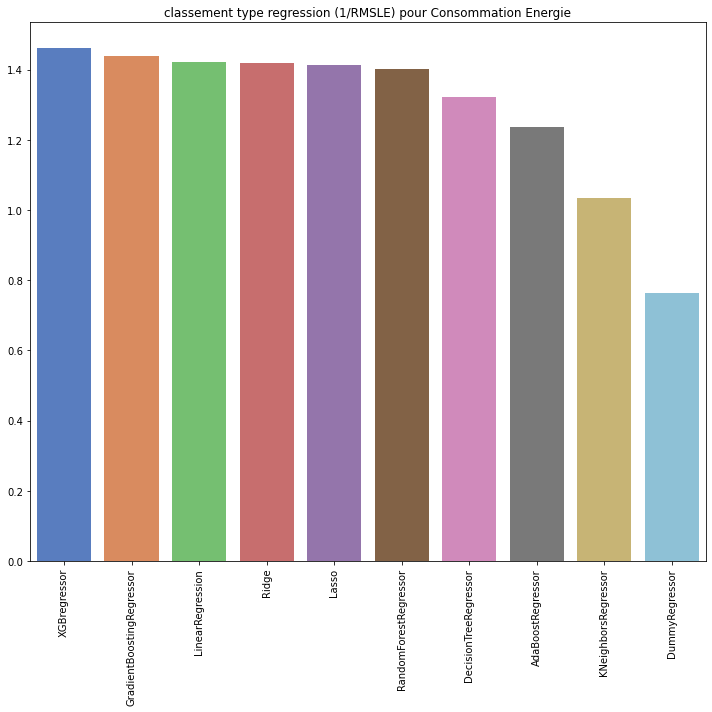

In [33]:
tabl_grap_x=[]
tabl_grap_y=[]
for li in list_sort:
    tabl_grap_x.append(li[0])
    tabl_grap_y.append(1/li[1][1])
    print(li[0],li[1][0],li[1][1])
plt.rcParams["figure.figsize"]=[10,10]
plt.title("classement type regression (1/RMSLE) pour Consommation Energie")
#plt.bar(tabl_grap_x,tabl_grap_y)
plt.xticks(rotation=90)
sns.barplot(x = tabl_grap_x,y = tabl_grap_y, palette="muted")
plt.tight_layout()
plt.savefig('P4_01_12_resultat_model.jpg')
plt.show()


In [35]:
xgbr = XGBRegressor(subsample = 0.7, reg_lambda = 1.1, gamma = 0.5, \
                    n_estimators = 150, max_depth = 4, min_child_weight = 3,\
                    learning_rate = 0.1,  colsample_bytree = 0.8)
xgbr.fit(X_train, y_train.values.ravel())


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=4,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=150, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1.1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [36]:
xgbr.feature_importances_

array([0.02302762, 0.03273526, 0.02627024, 0.08844364, 0.01574625,
       0.02244132, 0.01471433, 0.02055935, 0.01808378, 0.03398389,
       0.02294165, 0.01657819, 0.01316466, 0.01391587, 0.01448568,
       0.01295553, 0.01736666, 0.01296679, 0.        , 0.03056039,
       0.00614375, 0.00828693, 0.        , 0.        , 0.02259243,
       0.01242398, 0.02603075, 0.04561429, 0.02762277, 0.01378721,
       0.00905857, 0.        , 0.01566579, 0.        , 0.04095126,
       0.01763768, 0.01582675, 0.07782785, 0.0296561 , 0.05185261,
       0.110648  , 0.0174322 ], dtype=float32)

Text(0.5, 59.139999999999944, 'Relative Importance')

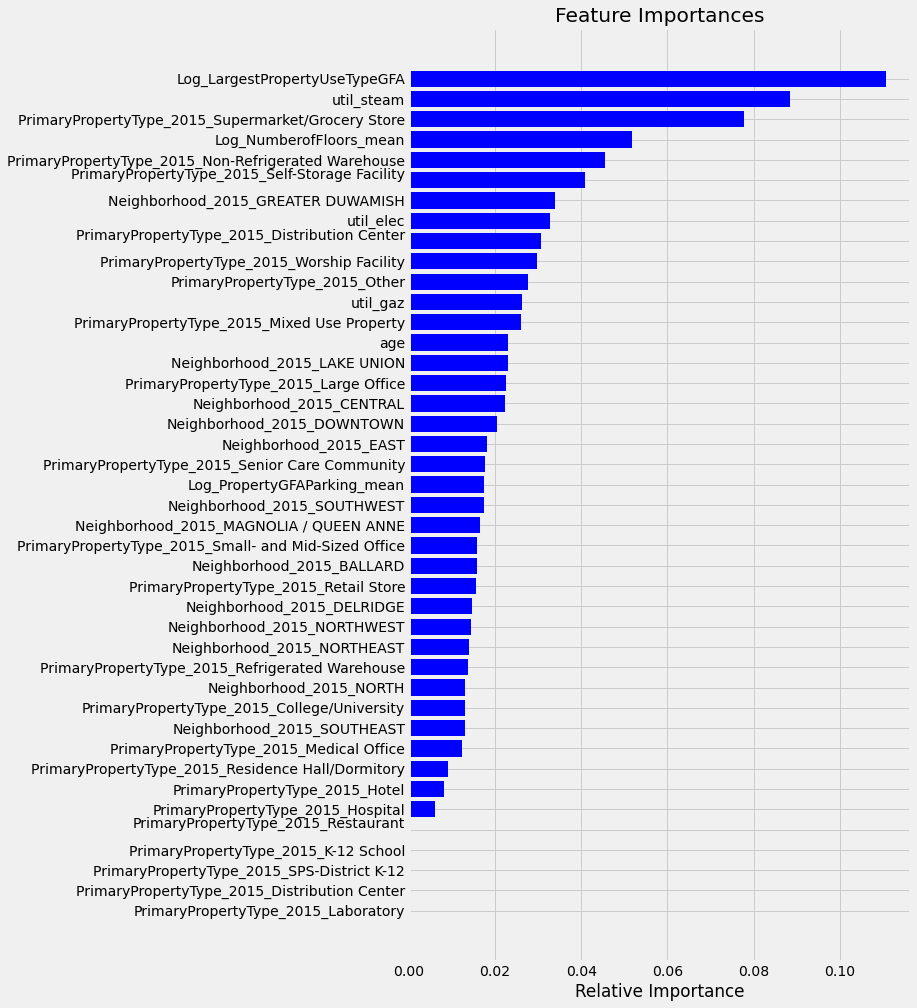

In [38]:
liste_variables=X_train.columns
importances = xgbr.feature_importances_
indices = np.argsort(importances)

# style du graphique 
plt.figure(figsize=(8,16))
plt.style.use('fivethirtyeight')
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [liste_variables[i] for i in indices])
plt.savefig('P4_01_13_feature_importance.jpg')
plt.xlabel('Relative Importance')